#### Imports

In [0]:
%matplotlib inline
import networkx as nx
from networkx.algorithms.community.quality import performance, modularity
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import urllib
import sys
import os
from google.colab import drive

#### Helper functions

In [0]:
# Get node positions using palslayout

file = urllib.request.urlretrieve('https://github.com/kalngyk/repoman/raw/master/palslayout.so', 'palslayout.so')
import palslayout

def getpos(G, communities):
    node2idx = dict([(x, i) for (i, x) in enumerate(G.nodes)])
    clusters = []
    for n, c in enumerate(communities):
        indices = [node2idx[x] for x in G.nodes if x in c]
        for i in indices:
            clusters.append([i, n])
    clusters = np.array(clusters)
    edges = np.array([[node2idx[x], node2idx[y]] for x, y in G.edges])
    pos = palslayout.getpos(edges, clusters)
    nodes = np.array(G.nodes)
    results = dict([(nodes[int(i)], np.array([j, k])) for i, j, k in pos])
    return results

#### Give access to Google Drive

In [4]:
savedir = ""
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    savedir = "/content/gdrive/My Drive/colab/"
    try:
        os.mkdir(savedir)
    except FileExistsError:
        print("Directory \"%s\" already exists" % (savedir))
root_path = "/content/gdrive/My Drive/CD-Project-shared/Project/"
sys.path.append(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Directory "/content/gdrive/My Drive/colab/" already exists


####Import self-made library

In [0]:
import readwrite
from girvan_newman import girvan_newman
from label_propagation import label_propagation
from markov_cluster import markov_cluster

tsv_path = root_path + "tsv/"
gml_path = root_path + "gml/"
pkl_path = root_path + "pkl/"
txt_path = root_path + "txt/"
png_path = root_path + "png/"

####Construct adjacency matrix and get statistics

maximum threshold to guarantee connectness: 0.07626666666666665


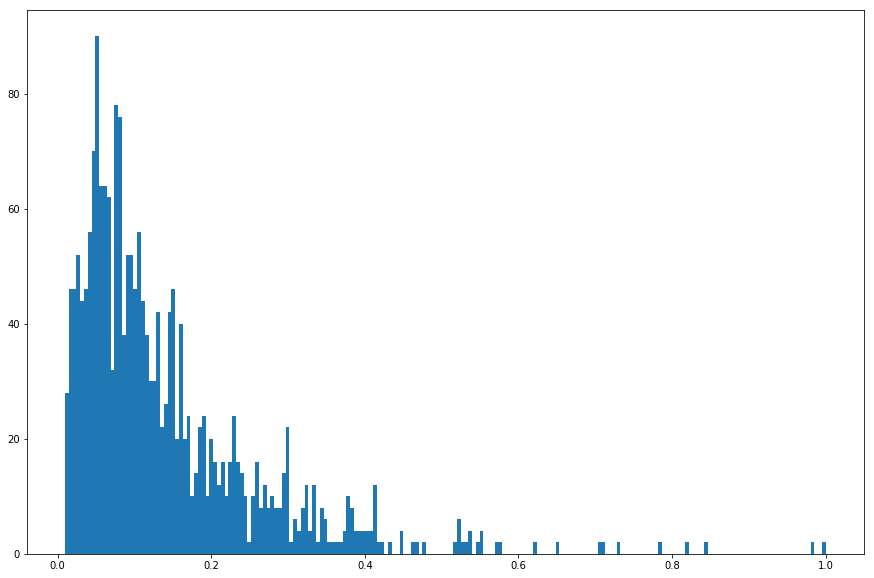

In [11]:
# construct adjacency matrix and label list
data = "project_star_100_v1"
tsv_file_path = tsv_path + data + ".tsv"
adjmat, labels = readwrite.import_tsv_mat(tsv_file_path, directed=False)

# plot all the non-zero weights in a histogram
plt.figure(figsize=(15, 10))
_ = plt.hist(adjmat[adjmat != 0].reshape(-1), bins=200)

# compute the maximum threshold that guarantees connectness of the graph
weights = np.array([np.hstack((adjmat[i,:], adjmat[:,i])) for i in range(adjmat.shape[0])])
max_threshold = np.min(np.max(weights, axis=1))
print("maximum threshold to guarantee connectness:", max_threshold)

####Filter the adjacency matrix, build the graph, and detect communites

In [12]:
# prepare community detection algorithms
algorithms = ["GN", "LP", "MC"]
functions = [girvan_newman, label_propagation, markov_cluster]
filelist = []

# filter the adjacency matrix
threshold = 0.07
filtered_adjmat = np.copy(adjmat)
filtered_adjmat[filtered_adjmat < threshold] = 0

# build the graph
G = readwrite.mat2graph(filtered_adjmat, labels)

for algorithm, function in zip(algorithms, functions):
    # define file paths
    filename = data + "_" + str(threshold) + "_" + algorithm
    # gml_file_path = gml_path + filename + ".gml"
    txt_file_path = txt_path + filename + ".txt"
    pkl_file_path = pkl_path + filename + ".pkl"

    # community detection
    if function == girvan_newman:
        communities = function(G, 10, autothreshold=True)
    elif function == label_propagation:
        communities = function(G, iterNum=6)
    elif function == markov_cluster:
        communities = function(G, power=5, inflation=5, numIter=20, decimals=4)
    else:
        communities = []

    # report some key results to stdout
    print(algorithm+":", len(communities), modularity(G, communities), performance(G, communities))

    readwrite.export_pkl(G, communities, pkl_file_path)
    readwrite.export_txt(G, communities, data, algorithm, threshold, txt_file_path)
    filelist.append(filename)

GN: 7 0.11980930807456405 0.5274261603375527
[Done] export pkl file: /content/gdrive/My Drive/CD-Project-shared/Project/pkl/project_star_100_v1_0.07_GN.pkl
[Done] export txt file: /content/gdrive/My Drive/CD-Project-shared/Project/txt/project_star_100_v1_0.07_GN.txt
LP: 7 0.2699701487753543 0.6952288218111002
[Done] export pkl file: /content/gdrive/My Drive/CD-Project-shared/Project/pkl/project_star_100_v1_0.07_LP.pkl
[Done] export txt file: /content/gdrive/My Drive/CD-Project-shared/Project/txt/project_star_100_v1_0.07_LP.txt
MC: 12 0.11230373614794313 0.6092177864329763
[Done] export pkl file: /content/gdrive/My Drive/CD-Project-shared/Project/pkl/project_star_100_v1_0.07_MC.pkl
[Done] export txt file: /content/gdrive/My Drive/CD-Project-shared/Project/txt/project_star_100_v1_0.07_MC.txt


project_star_100_v1_0.07_GN


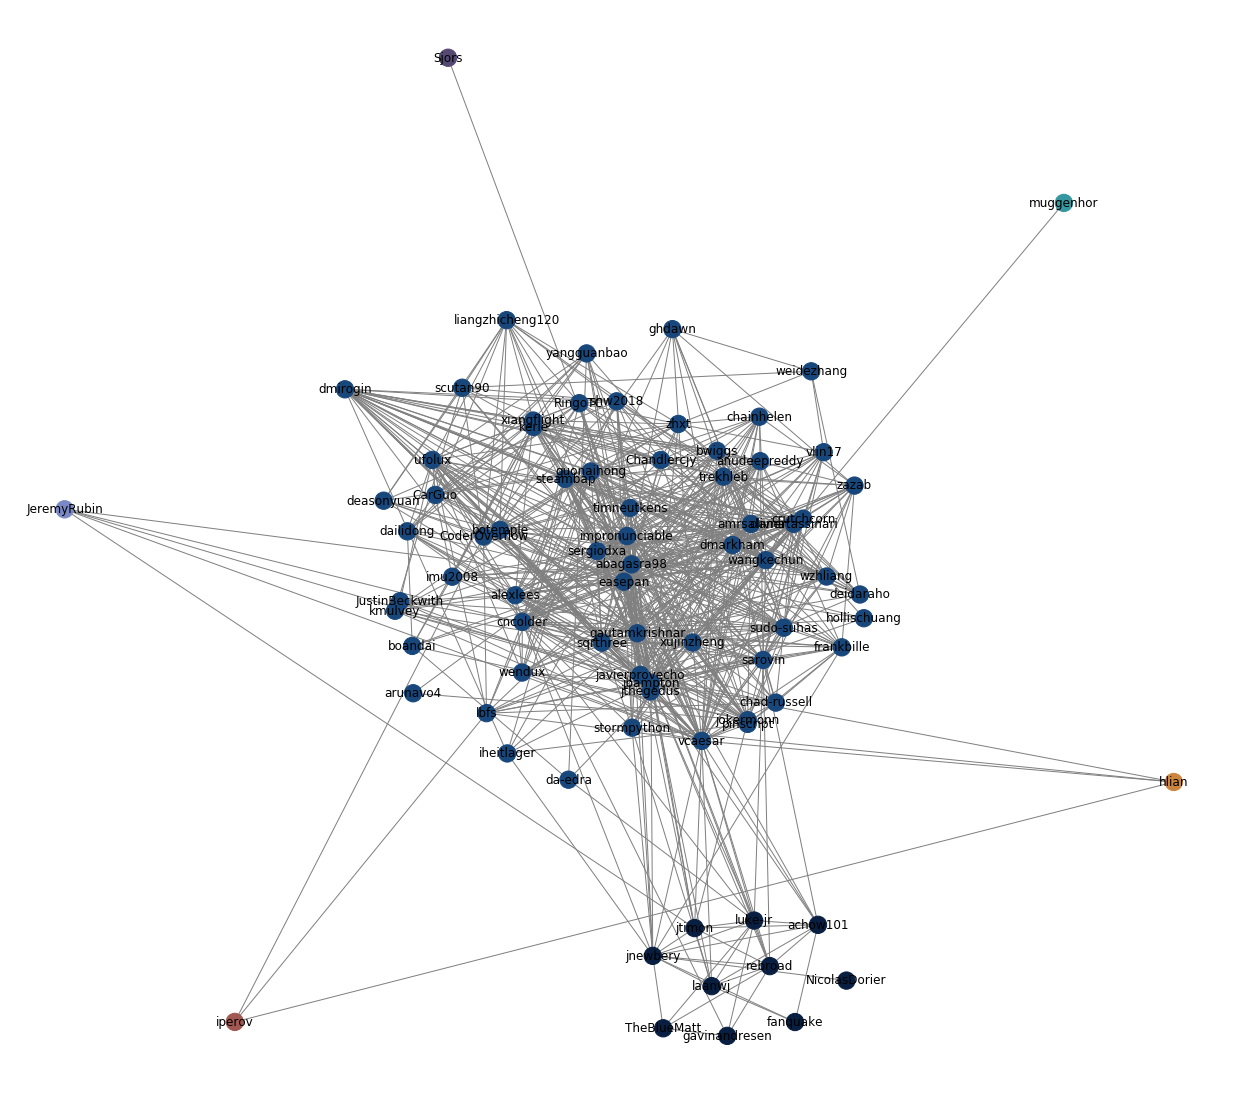

project_star_100_v1_0.07_LP


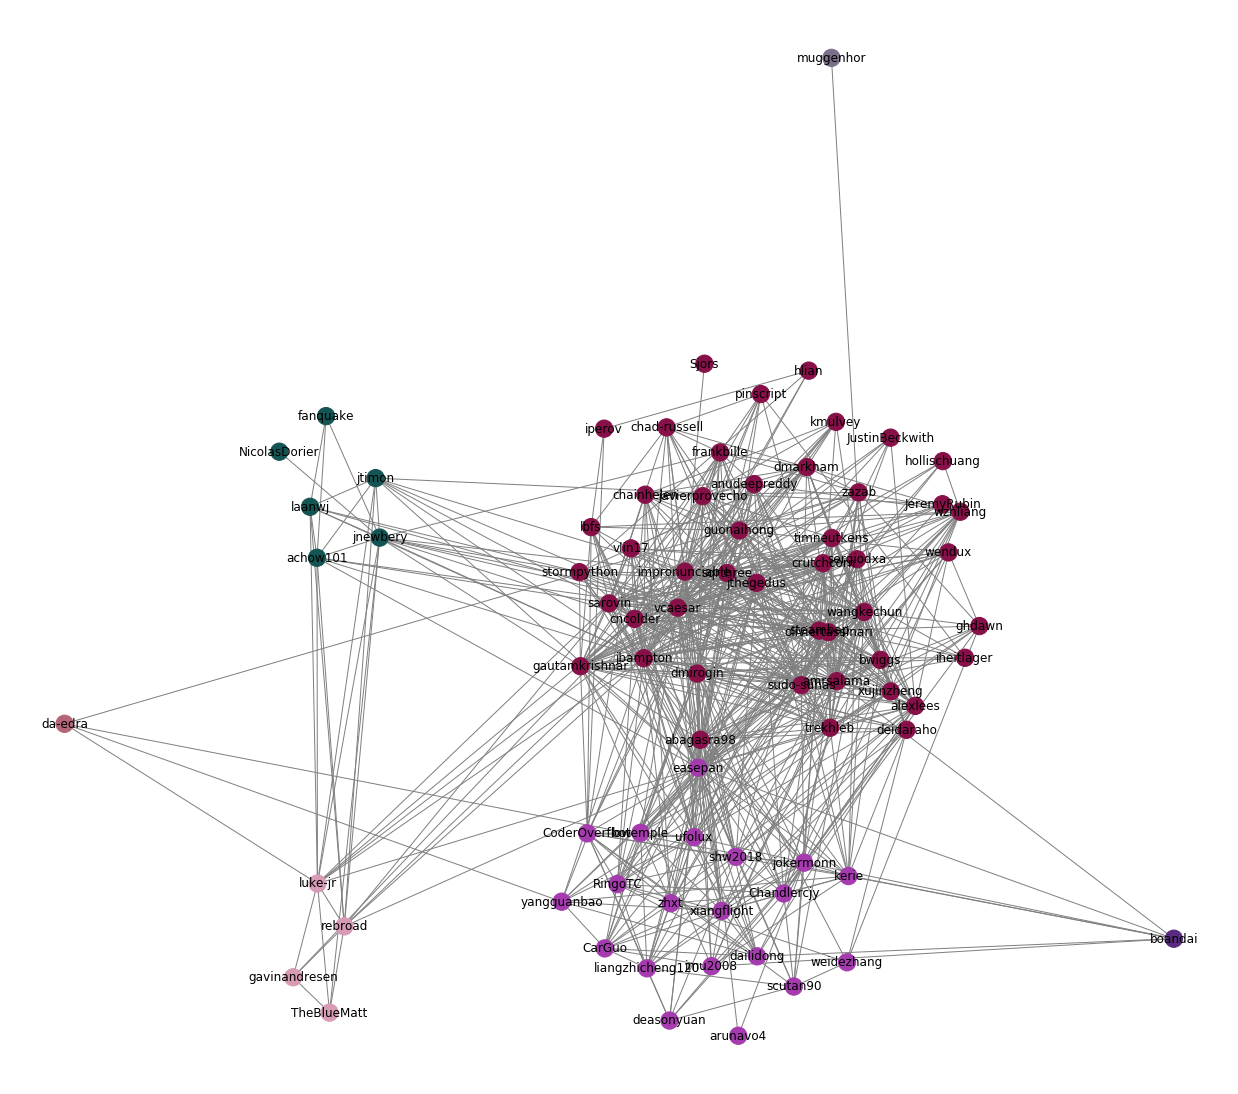

project_star_100_v1_0.07_MC


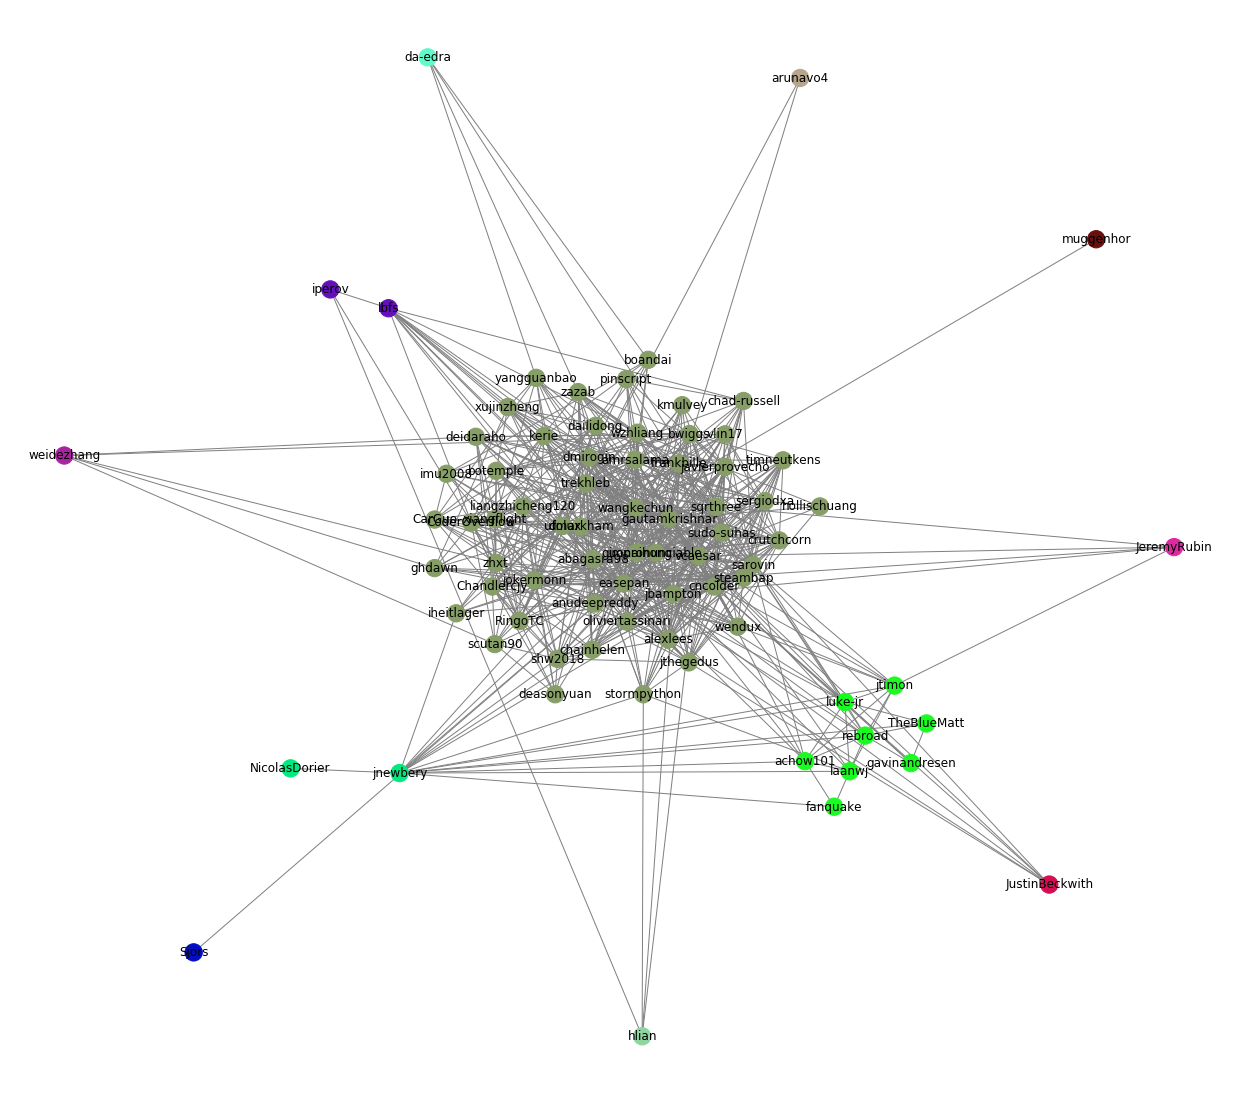

In [13]:
import pickle
from random import random

for filename in filelist:
    print(filename)
    pklfilename = pkl_path + filename + ".pkl"
    with open(pklfilename, 'rb') as f:
        G, communities = pickle.load(f)
    
    # Find nodes layout using pals
    pos = getpos(G, communities)
    
    # Gives colors to the clusters
    color_map = []
    cls_elem_count = np.array([len(c) for c in communities])
    n2c = dict()
    for i, c in enumerate(communities):
        for n in c:
            n2c[str(n)] = i
            
#     palette = sns.color_palette(None, len(cls_elem_count[cls_elem_count > 1]))
#     palette = sns.color_palette(None, len(cls_elem_count))
    palette = []
    for i in range(len(cls_elem_count)):
        palette.append((random(), random(), random()))
    
    for node in G.nodes:
        c = n2c[node]
#         if cls_elem_count[c] == 1:
#             idx = 0
#         else:
#             idx = c % len(palette)
        idx = c % len(palette)
        color_map.append(palette[idx])

    png_file_path = png_path + filename + ".png"
    plt.figure(figsize=(17, 15))
    nx.draw(G, pos=pos, node_color=color_map, edge_color='grey', with_labels=True)
    plt.savefig(png_file_path)
    plt.show()